In [2]:

# Paraproduct dependencies
from scipy.io import savemat,loadmat
import sys,os
sys.path.append(os.path.abspath('./Julia_allcodes_plus_dependencies/pyquest-master/'))
sys.path.append(os.path.abspath('./Tensor_Paraproducts'))
import matplotlib.pyplot as plt
import tensor_paraproducts
import numpy as np
import math
import torch

# Questionnaire dependencies
from imports import *
import questionnaire2 as q2coif
import questionnaire3 as q3coif
from scipy.spatial.distance import pdist, squareform
from scipy.io import savemat,loadmat
import random

# Define questionnaire parameters/functions

In [11]:

## Parameters
switchcos = 1
kwargs = {}
kwargs["threshold"] = 0.0
kwargs["row_alpha"] = 1.0
kwargs["col_alpha"] = 1.0
kwargs["row_beta"] = 0.0
kwargs["col_beta"] = 0.0
kwargs["tree_constant"] = 1.0
kwargs["n_iters"] = 10 ##number of iterations


def runquest(A,switchver=False,switchcos = 0,**kwargs):

    if switchcos > 0:
        init_row_aff = affinity.mutual_cosine_similarity(A.T, threshold=0.0)
        init_col_aff = affinity.mutual_cosine_similarity(A, threshold=0.0)
        params = q2coif.PyQuestParams(q2coif.INIT_AFF_COS_SIM,
                                      q2coif.TREE_TYPE_FLEXIBLE,
                                      q2coif.DUAL_EMD,
                                      q2coif.DUAL_EMD, **kwargs)
    else:
        init_row_aff = affinity.gaussian_euclidean(A.T)
        init_col_aff = affinity.gaussian_euclidean(A)
        params = q2coif.PyQuestParams(q2coif.INIT_AFF_GAUSSIAN,
                                      q2coif.TREE_TYPE_FLEXIBLE,
                                      q2coif.DUAL_EMD,
                                      q2coif.DUAL_EMD, **kwargs)

    init_row_vecs, init_row_vals = markov.markov_eigs(init_row_aff, 12)
    init_col_vecs, init_col_vals = markov.markov_eigs(init_col_aff, 12)
    if switchver:
        qrun = q2coif.pyquest(A, params)
    else:
        qrun = q3coif.pyquest(A, params)
    return qrun


def return_holder(data):

    D = squareform(pdist(data))
    epsilon = np.sqrt(np.median(D))
    kwargs["epsilon"] = epsilon
    
    oqrun = runquest(data,False,switchcos,**kwargs) ## Questionnaire tree
    row_tree=oqrun.row_trees[-1]
    col_tree=oqrun.col_trees[-1]
    
    coifman_col_order = [x.elements[0]  for x in col_tree.dfs_leaves()]
    coifman_row_order = [x.elements[0] for x in row_tree.dfs_leaves()]
    data_afterquest=data[np.ix_(coifman_row_order,coifman_col_order)]

    return data_afterquest


In [12]:

def get_lyr_head(ptidx,hdplyr):

    # Channel axis of 3D tensor was organized by appending all heads for each layer sequentially, not appending all layer for one head
    # ptidx = index of head along channel axis
    # hdplyr = number of attention heads in each layer

    headidx = ptidx % hdplyr
    lyridx = math.floor(ptidx/hdplyr)
    
    return lyridx, headidx


# Load data

In [3]:


# txl data load
txl_lyrs = 16
txl_hdplyr = 8
txl_nheads = nheads = txl_hdplyr * txl_lyrs
tokenlist = [0,1,2,4,5,6,7] # Tokens where organization works
batchidx = random.sample(tokenlist,k=1)
lyr_idx = np.random.randint(0,txl_lyrs,1)[0]
headidx = np.random.randint(0,txl_hdplyr,1)


fname = "attn_data/attn_data_" + str(lyr_idx) + ".pth"
model = torch.load(fname, map_location=torch.device("cpu"))
f_txl = model[:, :,batchidx,headidx].numpy().astype(np.float64).squeeze()


# vit data load
#data = torch.load('/home/of56/Documents/attentions_CIFAR_5_14.pt')
data = torch.load('./attentions_CIFAR/ViT_NORM_attentions_CIFAR_test_1_EP_finetune.pt')
nvit_pts = 10
vit_hdplyr = 12
nvitlyr = 12
vit_lyridx = np.random.randint(0,nvitlyr,1)
vit_hdidx = np.random.randint(0,vit_hdplyr,1)
batchidx = (np.random.randint(0,nvit_pts,1)*vit_hdplyr) + vit_lyridx
f_vit = data[batchidx[0]][1].squeeze()[vit_hdidx,:,:].squeeze().numpy().astype(np.float64)


print(f_txl.shape)
print(f_vit.shape)

# need to make vit matrix a power of 2. 
vitdim = f_vit.shape[0]
nvitdim = 128
centvit = round(f_vit.shape[0]/2)
f_vit = f_vit[centvit-64:centvit+64,centvit-64:centvit+64]
print(f_vit.shape)




(256, 256)
(197, 197)
(128, 128)


/tmp/ipykernel_1052873/156709555.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(fname, map_location=torch.device("cpu"))
/tmp/ipykernel_1052873/1567

In [14]:

# Generate Holder matrices
f_txl_holder = return_holder(f_txl)
f_vit_holder = return_holder(f_vit)


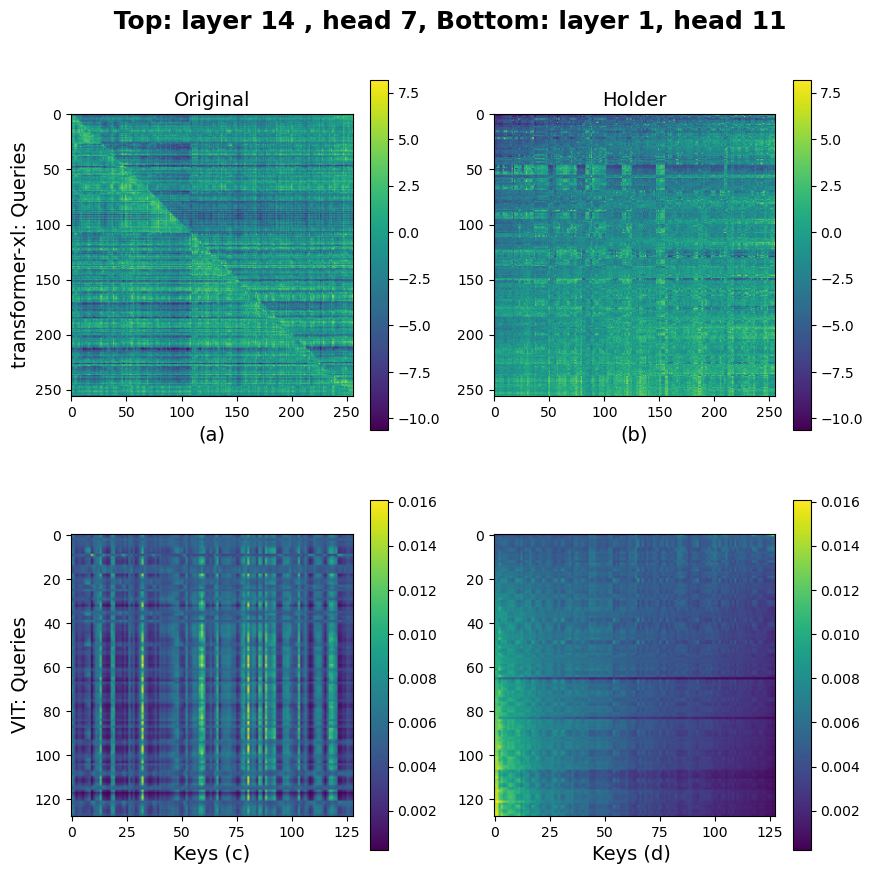

In [15]:


figs,axs = plt.subplots(2,2,figsize=(10,10))

plt.suptitle(f" Top: layer {lyr_idx} , head {headidx[0]}, Bottom: layer {vit_lyridx[0]}, head {vit_hdidx[0]}",fontsize=18,y=0.95,fontweight='bold')

img0 = axs[0,0].imshow(f_txl)
axs[0,0].set_title("Original",fontsize=14)
axs[0,0].set_ylabel("transformer-xl: Queries",fontsize=14)
axs[0,0].set_xlabel("(a)",fontsize=14)
figs.colorbar(img0, ax=axs[0,0])

img1 = axs[0,1].imshow(f_txl_holder)
figs.colorbar(img1, ax=axs[0,1])
axs[0,1].set_title("Holder",fontsize=14)
axs[0,1].set_xlabel("(b)",fontsize=14)

img2 = axs[1,0].imshow(f_vit)
axs[1,0].set_xlabel("Keys (c)",fontsize=14)
axs[1,0].set_ylabel("VIT: Queries",fontsize=14)
figs.colorbar(img2, ax=axs[1,0])

img3 = axs[1,1].imshow(f_vit_holder)
axs[1,1].set_xlabel("Keys (d) ",fontsize=14)
figs.colorbar(img3, ax=axs[1,1])

plt.savefig("./paraproduct_experiments/twohead_subplot_txl_vit.png")




# Paraproduct Decompositions

In [16]:

NX = f_txl.shape[0]
NY = f_txl.shape[1]
jmax = int(math.log2(NX) - 2)
jpmax = int(math.log2(NY) - 2)
jxrng = list(range(4,jmax)) # Define range of scales
jyrng = list(range(4,jpmax))
ivar = 'softmax'


#get original nonlinear transformation
ononlin_txl = np.exp(f_txl)
rowsums = np.sum(ononlin_txl,axis=1)
sft_ononlin_txl = np.zeros((NX,NY))
for i in range(ononlin_txl.shape[0]):
    sft_ononlin_txl[i,:] = ononlin_txl[i,:]/rowsums[i]  


#get tensor paraproduct decomposition 
inst_decomp = tensor_paraproducts.tensor_paraproducts_haar(f_txl_holder,sft_ononlin_txl,ivar)
decompout = inst_decomp.paraproduct_decomp(jxrng,jyrng)
totalapptxl = decompout['total']

In [17]:



NX = f_vit.shape[0]
NY = f_vit.shape[1]
jmax = int(math.log2(NX) - 2)
jpmax = int(math.log2(NY) - 2)
jxrng = list(range(4,jmax)) # Define range of scales
jyrng = list(range(4,jpmax))
ivar = 'softmax'


#get original nonlinear transformation
ononlin_vit = np.exp(f_vit)
rowsums = np.sum(ononlin_vit,axis=1)
sft_ononlin_vit = np.zeros((NX,NY))
for i in range(ononlin_vit.shape[0]):
    sft_ononlin_vit[i,:] = ononlin_vit[i,:]/rowsums[i]  
 


#get tensor paraproduct decomposition 
inst_decomp = tensor_paraproducts.tensor_paraproducts_haar(f_vit_holder,sft_ononlin_vit,ivar)
decompout = inst_decomp.paraproduct_decomp(jxrng,jyrng)
totalappvit = decompout['total']





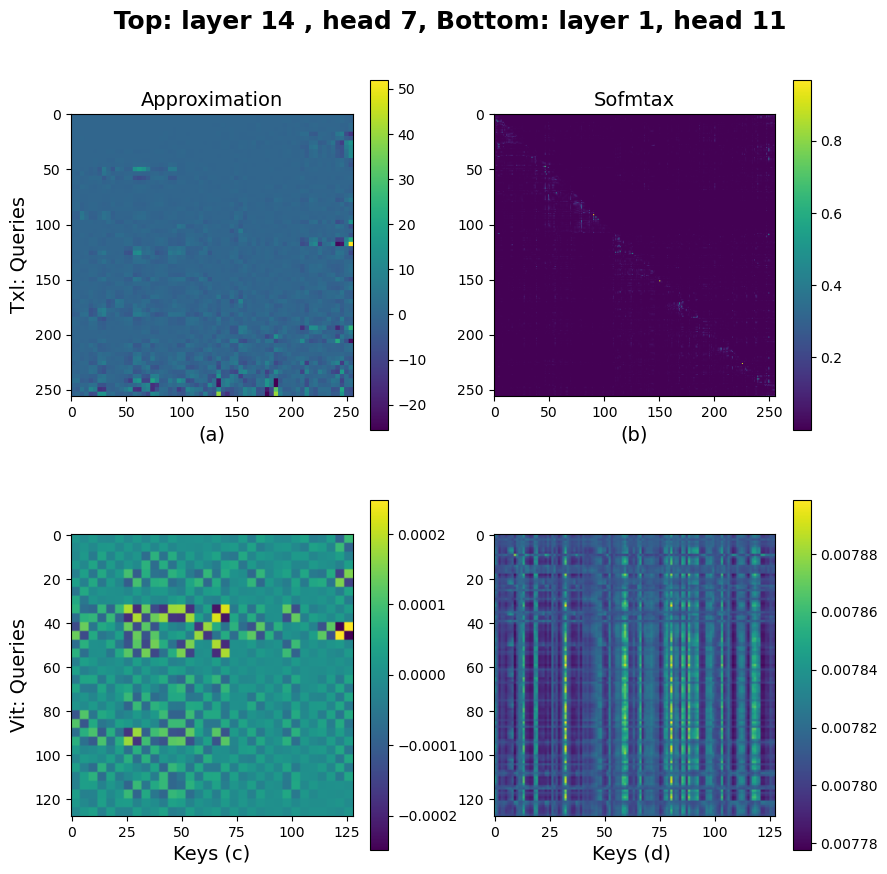

In [18]:

figs,axs = plt.subplots(2,2,figsize=(10,10))


plt.suptitle(f" Top: layer {lyr_idx} , head {headidx[0]}, Bottom: layer {vit_lyridx[0]}, head {vit_hdidx[0]}",fontsize=18,y=0.95,fontweight='bold')

img0 = axs[0,0].imshow(totalapptxl)
axs[0,0].set_title("Approximation",fontsize=14)
axs[0,0].set_ylabel("Txl: Queries",fontsize=14)
axs[0,0].set_xlabel("(a)",fontsize=14)
figs.colorbar(img0, ax=axs[0,0])

img1 = axs[0,1].imshow(sft_ononlin_txl)
axs[0,1].set_title("Sofmtax",fontsize=14)
figs.colorbar(img1, ax=axs[0,1])
axs[0,1].set_xlabel("(b)",fontsize=14)

img2 = axs[1,0].imshow(totalappvit)
axs[1,0].set_xlabel("Keys (c)",fontsize=14)
axs[1,0].set_ylabel("Vit: Queries",fontsize=14)
figs.colorbar(img2, ax=axs[1,0])

img3 = axs[1,1].imshow(sft_ononlin_vit)
axs[1,1].set_xlabel("Keys (d) ",fontsize=14)
figs.colorbar(img3, ax=axs[1,1])


plt.savefig("./Interpretability_transformer/paraproduct_experiments/softmax_invariance_txl_vit.png")

